In [130]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns



In [2]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACGUN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'U':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [3]:
one_hot_encode("ACGU")

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

### Загрузка датасета бинов

In [161]:

prob = pd.read_csv('20long.csv') # сразу загружается таблица бинов
#prob["binary"] = prob.max(axis = 1)
#prob.loc[prob['F3 probability'] < 0.6, 'binary'] = 0
#prob.loc[prob['F4 probability'] < 0.6, 'binary'] = 0 
prob.loc[prob['F7 probability'] < 0.6, 'binary'] = 0
prob.loc[prob['F8 probability'] < 0.6, 'binary'] = 0
#prob.loc[prob['F3 probability'] > 0.6, 'binary'] = 1
#prob.loc[prob['F4 probability'] > 0.6, 'binary'] = 1 
prob.loc[prob['F7 probability'] > 0.6, 'binary'] = 1 
prob.loc[prob['F8 probability'] > 0.6, 'binary'] = 1 

prob.binary = prob.binary.astype(int)
print(prob[prob["F2 probability"] >= 0.6].shape)
print(prob[prob["F2 probability"] < 0.6].shape)

(1934, 10)
(9758, 10)


In [84]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

### Разделение на train-test

In [85]:
full_train_df, test_df = quick_split(prob)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)
print("Train.1:", train_df[train_df["binary"] == 1].shape)
print("Train.0:", train_df[train_df["binary"] == 0].shape)

Train: (7482, 10)
Val: (1871, 10)
Test: (2339, 10)
Train.1: (4886, 10)
Train.0: (2596, 10)


#### Если использовать в таблице бины для фракций 1 2 3 4, то примерно шестая часть записей в каждом датафрейме имеет y_true = 1
#### Если используются фракции 2 3 4, то положительных ответов примерно столько же сколько отрицательных

#### Создание датасета OHE - y_true

In [86]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='binary'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values) # лист всех последовательностей
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
        
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)

        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

### Даталоадер

In [87]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='binary',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [88]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

## Линейная модель

In [55]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        # the 4 is for our one-hot encoded vector length 4!
        self.lin1 = nn.Linear(4*seq_len,1)
        
        self.S = nn.Sigmoid()

        

    def forward(self, x):
        
        # reshape to flatten sequence dimension
        x = x.view(x.shape[0],self.seq_len*4)
        
        # Linear wraps up the weights/bias dot product operations
        x = self.lin1(x)
        
        x = self.S(x)

        
        return x
        #return out

   

## Сверточная модель

In [56]:
# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=23*4,
                 kernel_size=7):
        super().__init__()
        
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            
            # 4 is for the 4 nucleotides
            nn.Conv1d(in_channels=4, out_channels = num_filters, kernel_size=kernel_size), # 23*4*(7-2+1)
            
            nn.Sigmoid(),
            
            nn.Flatten(),
            
            nn.Linear(num_filters*(seq_len-kernel_size+1), 32),
            
            nn.Sigmoid(),
            
            nn.Linear(32,1),
            
            nn.Sigmoid()
        ) 
    def forward(self, x):
        
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        x = x.permute(0,2,1) 
        
        #print(xb.shape)
        x = self.conv_net(x)
        return x
    

## small cnn

In [81]:
class small_cnn(nn.Module):
    def __init__(self,
                seq_len,
                block_sizes=[16, 24, 32, 40, 48],
                kernel_size=7):
        
        super().__init__()
        self.seq_len = seq_len
      
        nn_blocks = []
      
        for in_bs, out_bs in zip([4] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=1),
                nn.Sigmoid(),
                nn.BatchNorm1d(out_bs)
            )
            
            nn_blocks.append(block)
            
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * (seq_len + len(block_sizes)*(3-kernel_size)), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        x = x.permute(0,2,1) 
        
        out = self.conv_net(x)
        
        return out

### функция потерь FocalLoss

In [58]:
"""https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/4"""
class FocalLoss(nn.Module):

    def __init__(self, alpha = 0.25, gamma = 2.0):
        super(FocalLoss, self).__init__()
        self.gamma = torch.tensor(gamma, dtype = torch.float32)
        self.alpha = alpha
        self.eps = 1e-6

    def forward(self, input, target):
        
        BCE_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

### Лосс-функция 

In [59]:
def loss_batch(model, loss_func, x, y, opt=None):
    
    logits = model(x.float())
    
    loss = loss_func(logits, y.float())
    
    if opt is not None: # Вывод для train
        
        opt.zero_grad()
        
        loss.backward()
        
        opt.step()
        
        return loss.item(), len(x)

    return loss.item(), len(x), logits # Вывод для val

### Train + Val

In [60]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    
    # loop through train DataLoader
    for batch in train_dl:
        
        # take seq, labels
        x, y = batch
        
        # put on GPU
        x, y = x.to(device),y.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, x, y, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

In [61]:
def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for batch in val_dl:
            
            # take seq, labels
            x, y = batch
            
            # put on GPU
            x, y = x.to(device),y.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n, logits = loss_batch(model, loss_func, x, y)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)
            
            
            y_pred = torch.argmax(logits, dim=1)
            
            
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(y.numpy())

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    roc_auc = roc_auc_score(y_true = y_true_list, y_score = y_pred_list)
    
    
    return val_loss, roc_auc
    


### fit

In [62]:
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in tqdm(range(epochs)):
        
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss, acc = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses




### run_model функция

In [116]:
def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=300, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt(model.parameters(), lr=lr)
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

### Запускаем Модель Model_lin

In [117]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE,
    lossf = FocalLoss(),
    opt = torch.optim.AdamW
)

  0%|          | 0/300 [00:00<?, ?it/s]

E0 | train loss: 0.037 | val loss: 0.035
E1 | train loss: 0.034 | val loss: 0.034
E2 | train loss: 0.032 | val loss: 0.033
E3 | train loss: 0.032 | val loss: 0.032
E4 | train loss: 0.032 | val loss: 0.032
E5 | train loss: 0.031 | val loss: 0.032
E6 | train loss: 0.031 | val loss: 0.032
E7 | train loss: 0.031 | val loss: 0.032
E8 | train loss: 0.031 | val loss: 0.032
E9 | train loss: 0.031 | val loss: 0.032
E10 | train loss: 0.031 | val loss: 0.032
E11 | train loss: 0.031 | val loss: 0.032
E12 | train loss: 0.031 | val loss: 0.032
E13 | train loss: 0.031 | val loss: 0.032
E14 | train loss: 0.031 | val loss: 0.031
E15 | train loss: 0.031 | val loss: 0.031
E16 | train loss: 0.031 | val loss: 0.031
E17 | train loss: 0.031 | val loss: 0.031
E18 | train loss: 0.031 | val loss: 0.031
E19 | train loss: 0.031 | val loss: 0.031
E20 | train loss: 0.031 | val loss: 0.031
E21 | train loss: 0.030 | val loss: 0.031
E22 | train loss: 0.030 | val loss: 0.031
E23 | train loss: 0.030 | val loss: 0.031
E2

E195 | train loss: 0.030 | val loss: 0.031
E196 | train loss: 0.030 | val loss: 0.031
E197 | train loss: 0.030 | val loss: 0.031
E198 | train loss: 0.030 | val loss: 0.031
E199 | train loss: 0.030 | val loss: 0.031
E200 | train loss: 0.030 | val loss: 0.031
E201 | train loss: 0.030 | val loss: 0.031
E202 | train loss: 0.030 | val loss: 0.031
E203 | train loss: 0.030 | val loss: 0.031
E204 | train loss: 0.030 | val loss: 0.031
E205 | train loss: 0.030 | val loss: 0.031
E206 | train loss: 0.030 | val loss: 0.031
E207 | train loss: 0.030 | val loss: 0.031
E208 | train loss: 0.030 | val loss: 0.031
E209 | train loss: 0.030 | val loss: 0.031
E210 | train loss: 0.030 | val loss: 0.031
E211 | train loss: 0.030 | val loss: 0.031
E212 | train loss: 0.030 | val loss: 0.031
E213 | train loss: 0.030 | val loss: 0.031
E214 | train loss: 0.030 | val loss: 0.031
E215 | train loss: 0.030 | val loss: 0.031
E216 | train loss: 0.030 | val loss: 0.031
E217 | train loss: 0.030 | val loss: 0.031
E218 | trai

In [91]:
def quick_loss_plot(data_label_list,loss_type="BCE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

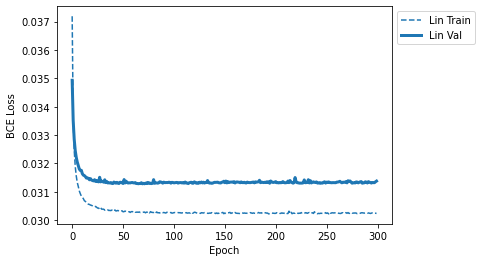

In [119]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

### Запускаем Модель Model_cnn

In [94]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE,
    lossf = FocalLoss(),
    opt = torch.optim.AdamW
)

  0%|          | 0/100 [00:00<?, ?it/s]

E0 | train loss: 0.041 | val loss: 0.041
E1 | train loss: 0.041 | val loss: 0.041
E2 | train loss: 0.041 | val loss: 0.041
E3 | train loss: 0.041 | val loss: 0.041
E4 | train loss: 0.041 | val loss: 0.041
E5 | train loss: 0.041 | val loss: 0.041
E6 | train loss: 0.041 | val loss: 0.041
E7 | train loss: 0.041 | val loss: 0.041
E8 | train loss: 0.041 | val loss: 0.041
E9 | train loss: 0.041 | val loss: 0.041
E10 | train loss: 0.041 | val loss: 0.041
E11 | train loss: 0.041 | val loss: 0.041
E12 | train loss: 0.041 | val loss: 0.041
E13 | train loss: 0.041 | val loss: 0.041
E14 | train loss: 0.041 | val loss: 0.041
E15 | train loss: 0.041 | val loss: 0.041
E16 | train loss: 0.041 | val loss: 0.041
E17 | train loss: 0.041 | val loss: 0.041
E18 | train loss: 0.041 | val loss: 0.041
E19 | train loss: 0.041 | val loss: 0.041
E20 | train loss: 0.041 | val loss: 0.041
E21 | train loss: 0.041 | val loss: 0.041
E22 | train loss: 0.041 | val loss: 0.041
E23 | train loss: 0.041 | val loss: 0.041
E2

In [128]:
for x,y in train_dl:
    print(x.shape,y.shape)
    break
test_df[test_df["binary"] == 0].shape

torch.Size([128, 23, 4]) torch.Size([128, 1])


(874, 10)

In [120]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = small_cnn(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE,
    lossf = FocalLoss(),
    opt = torch.optim.AdamW
)

  0%|          | 0/300 [00:00<?, ?it/s]

E0 | train loss: 0.033 | val loss: 0.032
E1 | train loss: 0.031 | val loss: 0.033
E2 | train loss: 0.030 | val loss: 0.031
E3 | train loss: 0.029 | val loss: 0.030
E4 | train loss: 0.029 | val loss: 0.031
E5 | train loss: 0.029 | val loss: 0.038
E6 | train loss: 0.029 | val loss: 0.029
E7 | train loss: 0.028 | val loss: 0.029
E8 | train loss: 0.028 | val loss: 0.030
E9 | train loss: 0.028 | val loss: 0.030
E10 | train loss: 0.027 | val loss: 0.029
E11 | train loss: 0.027 | val loss: 0.030
E12 | train loss: 0.027 | val loss: 0.030
E13 | train loss: 0.027 | val loss: 0.030
E14 | train loss: 0.027 | val loss: 0.030
E15 | train loss: 0.027 | val loss: 0.030
E16 | train loss: 0.027 | val loss: 0.030
E17 | train loss: 0.027 | val loss: 0.030
E18 | train loss: 0.027 | val loss: 0.030
E19 | train loss: 0.027 | val loss: 0.029
E20 | train loss: 0.027 | val loss: 0.029
E21 | train loss: 0.026 | val loss: 0.030
E22 | train loss: 0.026 | val loss: 0.030
E23 | train loss: 0.026 | val loss: 0.029
E2

E194 | train loss: 0.025 | val loss: 0.031
E195 | train loss: 0.024 | val loss: 0.031
E196 | train loss: 0.024 | val loss: 0.030
E197 | train loss: 0.024 | val loss: 0.030
E198 | train loss: 0.024 | val loss: 0.030
E199 | train loss: 0.024 | val loss: 0.030
E200 | train loss: 0.024 | val loss: 0.030
E201 | train loss: 0.024 | val loss: 0.033
E202 | train loss: 0.024 | val loss: 0.030
E203 | train loss: 0.024 | val loss: 0.030
E204 | train loss: 0.024 | val loss: 0.031
E205 | train loss: 0.024 | val loss: 0.030
E206 | train loss: 0.024 | val loss: 0.032
E207 | train loss: 0.024 | val loss: 0.033
E208 | train loss: 0.024 | val loss: 0.031
E209 | train loss: 0.024 | val loss: 0.030
E210 | train loss: 0.024 | val loss: 0.030
E211 | train loss: 0.023 | val loss: 0.030
E212 | train loss: 0.023 | val loss: 0.031
E213 | train loss: 0.024 | val loss: 0.031
E214 | train loss: 0.024 | val loss: 0.031
E215 | train loss: 0.024 | val loss: 0.030
E216 | train loss: 0.024 | val loss: 0.030
E217 | trai

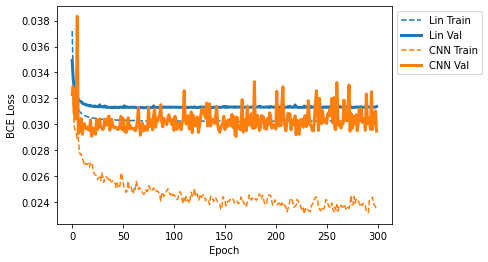

In [121]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

In [101]:
def quick_seq_pred(model, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    
    '''
    
    df = pd.DataFrame(data = {'seq': [], 'pred': [], 'actual': []})
    
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)# One_Hot_Encode
        
        pred = model(s.float()) # model predicted value
        
        actual = oracle[dna] # actual value
        
        df = df.append({'seq': dna, 'pred': pred.item(), 'actual': actual}, ignore_index = True)
    return df
    

In [102]:
def graph_roc(df,model):
    y_true=df["actual"]
    y_score=df["pred"]

    fpr, tpr, treshold = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    print("roc_auc_scor: ",auc_score)
    plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая {model}')
    plt.legend(loc="lower right")
    plt.show()

### ROC_AUC на валидации linear

In [103]:
oracle = dict(val_df[['seq','binary']].values)


df1 = quick_seq_pred(model_lin, oracle.keys(), oracle)

roc_auc_scor:  0.8538096138096138


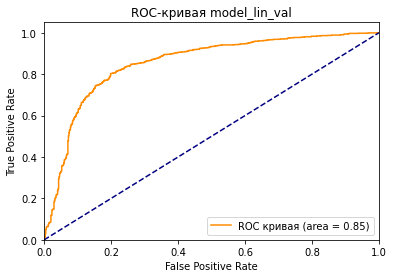

In [104]:
graph_roc(df1,"model_lin_val")

### ROC_AUC на тесте linear

In [105]:
oracle = dict(test_df[['seq','binary']].values)

df2 = quick_seq_pred(model_lin, oracle.keys(), oracle)

roc_auc_scor:  0.8769234073460844


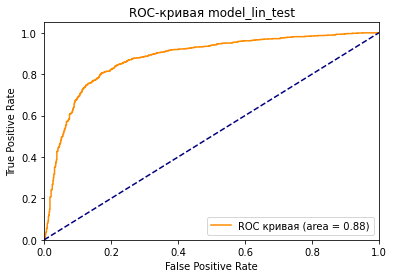

In [106]:
graph_roc(df2,"model_lin_test")

C:\Users\Niki\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


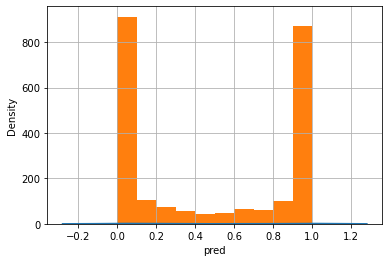

In [132]:
sns_plot = sns.distplot(df2['pred'])
fig = sns_plot.get_figure()
h = df2['pred'].hist()
fig = h.get_figure()

### ROC_AUC на валидации cnn

In [107]:
oracle = dict(val_df[['seq','binary']].values)

df3 = quick_seq_pred(model_cnn, oracle.keys(), oracle)

roc_auc_scor:  0.8918988218988219


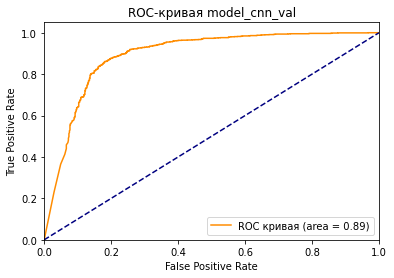

In [108]:
graph_roc(df3,"model_cnn_val")

### ROC_AUC на тесте cnn

In [109]:
oracle = dict(test_df[['seq','binary']].values)

df4 = quick_seq_pred(model_cnn, oracle.keys(), oracle)

roc_auc_scor:  0.9119574979889253


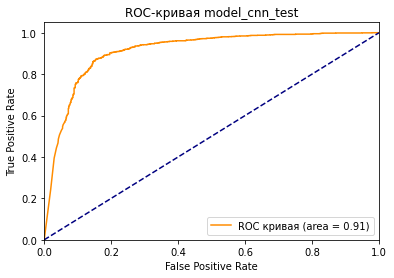

In [110]:
graph_roc(df4,"model_cnn_test")

In [122]:
df1[df1["pred"]>0.5]

,seq,pred,actual
5,AACCCAGCAGUACAUGCUUGAUG,0.999545,0.0
69,AGGAAAACAGUAUGAGAAAAAUG,0.978856,0.0
94,AUCAUAAAGUUGUUACCAUCAUG,0.632286,0.0
98,UAGAUUGAGAACCCACCUGCAUG,0.999950,0.0
103,UAAAAAGUAAUCCUUAGCGUAUG,0.999903,0.0
...,...,...,...
1861,AUGUGGGCCGCUACAACUACAUG,0.999999,1.0
1862,AUUGAGAGAAAUCAAAUAUCAUG,0.979964,1.0
1864,UAUGUACCUAAGGAGGGAGAAUG,0.666868,1.0
1865,UUCAAGCCACAGGAGCAUGAAUG,0.908704,1.0


In [123]:
df2[df2["pred"]>0.5]

,seq,pred,actual
2,GGCUUUGUCUACAUCUUUCAAUG,1.000000,0.0
25,AAACAUGUGAAUCCAGAAUCAUG,0.996997,0.0
36,AUAAUGGUCGUAAGAGGAGCAUG,0.917437,0.0
51,CAAAGAGGAGAUCAAAGACCAUG,0.824511,0.0
70,CUAUAUCCUACCUAUAAUCCAUG,1.000000,0.0
...,...,...,...
2323,AUCUCGGCAUUACACGACAUAUG,0.999945,1.0
2324,GCCAGCGGGGCUUUGGCGGUAUG,0.999428,1.0
2326,GAACAAAGUACACAAACACGAUG,0.999902,1.0
2331,GUUGCACAUAAAAGAGAAAAAUG,0.997651,1.0


In [124]:
df3[df3["pred"]>0.5]

,seq,pred,actual
5,AACCCAGCAGUACAUGCUUGAUG,1.000000,0.0
50,AAUGAUUUGUAGAGGUGUUUAUG,0.984649,0.0
63,AAAUAUAAGGAGCAACGCGAAUG,0.912745,0.0
69,AGGAAAACAGUAUGAGAAAAAUG,1.000000,0.0
94,AUCAUAAAGUUGUUACCAUCAUG,1.000000,0.0
...,...,...,...
1860,GUAAUUUACUGUGGCCUUGUAUG,1.000000,1.0
1861,AUGUGGGCCGCUACAACUACAUG,1.000000,1.0
1862,AUUGAGAGAAAUCAAAUAUCAUG,1.000000,1.0
1864,UAUGUACCUAAGGAGGGAGAAUG,0.979517,1.0


In [125]:
df4[df4["pred"]>0.5]

,seq,pred,actual
2,GGCUUUGUCUACAUCUUUCAAUG,1.000000,0.0
6,AUGCCAAAAGGAAAACAGGUAUG,0.985330,0.0
25,AAACAUGUGAAUCCAGAAUCAUG,1.000000,0.0
36,AUAAUGGUCGUAAGAGGAGCAUG,0.999981,0.0
70,CUAUAUCCUACCUAUAAUCCAUG,1.000000,0.0
...,...,...,...
2331,GUUGCACAUAAAAGAGAAAAAUG,0.999999,1.0
2334,UGUGAUAAAGGUUCUGUGUAAUG,1.000000,1.0
2335,ACAAACGUGGGAACAAAAUCAUG,0.760301,0.0
2337,CACAAGAAAGAAGGUGGAGCAUG,0.772339,0.0
